# Data Retrieval

In [1]:
from typing import Iterable, Union, Dict, Tuple
import pandas as pd
from IPython.core.display import display
from sklearn.metrics import label_ranking_average_precision_score, ndcg_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import normalize, minmax_scale

def getRawData():
    bug_report_raw=pd.read_pickle("Output/allBugReports.pickle")
    bug_report_raw = bug_report_raw[bug_report_raw['description'].notna()].reset_index()
    display(bug_report_raw)

    source_code_raw = pd.read_pickle("Output/allSourceCodes.pickle")
    source_code_raw = source_code_raw[source_code_raw['unprocessed_code'].notna()]
    display(source_code_raw)
    return bug_report_raw, source_code_raw

# Cleaning the Data

First, we clean up the discrepancies between the bug report dataset and source code dataset. Here, we remove the missing files so that the data will represent a more accurate analysis.

In [2]:
def filterBugReportsMissingFiles(bug_report_raw, source_code_raw):
    source_file_names_dot_format=set(source_code_raw["filename"].map(lambda fname:"org"+fname.partition("org")[2].replace("\\",".")).tolist())

    # create copy of bug report dataframe
    filter_missing_files = bug_report_raw.copy()

    # return the filenames that appear in the source code dataframe only
    for index, row in filter_missing_files.iterrows():
        filter_missing_files.at[index, "fix"] = list(set(row['fix']).intersection(source_file_names_dot_format))

    # filter out empty arrays
    filter_missing_files = filter_missing_files[filter_missing_files.fix.str.len()>0]
    return filter_missing_files

Next, we clean the textual data.  

Snowball Stemmer is used since it is a more powerful stemmer than what is used by the research paper on IRFL (Porter Stemmer).
  
In addition to NLTK's stop words, Python and Java keywords have been removed to provide a better model for analysis. The Python keywords will come from a built-in library called "keyword", while Java language keywords will be extracted from a file provided by the original GitHub source found here: https://github.com/exatoa/Bench4BL/blob/master/scripts/languages.txt

Camel case words such as setValue will be split into two words, "set" and "Value".

All letters will be turned into lowercases so there would not be any distinction between "Value" and "value", for example.

In [3]:
import re, string
import pandas as pd
import numpy as np
import keyword
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt 
import html

%matplotlib inline

stemmer = SnowballStemmer("english")

java_keywords = None
with open('languages.txt', 'r') as file:
    java_keywords = file.read().split('\n')

# set for o(1) lookup performance
stop_words = set(list(ENGLISH_STOP_WORDS) + keyword.kwlist + java_keywords)

def clean_text(text):
    # This is to remove the double html encodings such as &amp;apos; into simply &apos;.
    # This html encoding is easier to convert into punctuation or special characters for removal.
    text = text.replace("&amp;", '&')
    text = html.unescape(text)

    # split words and return them if it is not in the stop words list
    def getIndividualWords(all_text:str) ->Iterable[str]:
        # this regex splits apart camel case variables.
        # first half of | handles cases which are traditionally camel cased, or are just lower case.
        # second half of | handles cases where its all capital letters, ie a variable named VARIABLE
        # this also implicitly gets rid of any punctuation and any whitespace. This is because the regex
        # skips over any non-letter characters
        for word in re.findall('[A-Z]*[a-z]+|[A-Z]{2,}', all_text):
            word_lower=word.lower()
            if word_lower not in stop_words:
                yield stemmer.stem(word_lower)

    text=' '.join(getIndividualWords(text))
    return text

The first two tables show the original dataset, while the next two show the newly processed dataset.

In [4]:
def getProcessedData()->Tuple[Dict[str,pd.DataFrame],Dict[str,pd.DataFrame]]:
    bug_report_raw,source_code_raw=getRawData()
    filter_missing_files=filterBugReportsMissingFiles(bug_report_raw,source_code_raw)
    filter_missing_files["processed_description"]=filter_missing_files["description"].map(clean_text)
    filter_missing_files["processed_summary"]=filter_missing_files["summary"].map(clean_text)
    filter_missing_files["processed_all"]=filter_missing_files["processed_description"] + filter_missing_files["processed_summary"]
    filter_missing_files=filter_missing_files[["fix","processed_all","project"]]
    display(filter_missing_files)
    source_code_raw["processed_code"]=source_code_raw["unprocessed_code"].map(clean_text)
    source_code_raw=source_code_raw[["filename","processed_code","project"]]
    display(source_code_raw)

    valuesByNameDict={}
    grouped_code=source_code_raw.groupby(["project"])
    for project,files in filter_missing_files.groupby(["project"]):
        valuesByNameDict[project]=files, grouped_code.get_group(project)
    return valuesByNameDict

bugReportAndCodeByProject=getProcessedData()

,id,fix,text,fixdate,summary,description,project,average_precision
0,217,[org.apache.commons.collections.map.flat3map.j...,NaN,2006-07-18 22:02:11,Flat3Map.Entry.setValue() overwrites other Ent...,Flat3Map&amp;apos;s Entry objects will overwri...,COLLECTIONS,0.0
1,214,[org.apache.commons.collections.testextendedpr...,NaN,2006-07-18 22:44:33,ExtendedProperties - field include should be n...,"The field ""include"" in ExtendedProperties is c...",COLLECTIONS,0.0
2,222,[org.apache.commons.collections.testlistutils....,NaN,2006-08-18 19:01:22,CollectionUtils removeAll is actually retainAll,"The removeAll(Collection collection, Collectio...",COLLECTIONS,0.0
3,261,[org.apache.commons.collections.map.flat3map.j...,NaN,2007-08-20 14:11:54,Flat3Map.remove() does not return the correct ...,final Flat3Map m = new Flat3Map();\n ...,COLLECTIONS,0.0
4,264,[org.apache.commons.collections.fasttreemap.java],NaN,2007-08-31 09:39:59,FastTreeMap forgets the comparator,In line 359 and 582 of the current 3.2 release...,COLLECTIONS,0.0
...,...,...,...,...,...,...,...,...
1785,692,[org.wildfly.security.auth.realm.legacypropert...,NaN,2016-11-02 09:35:48,Add tests for special chars in LegacyPropertie...,Add tests for issue https://issues.jboss.org/b...,ELY,0.0
1786,691,[org.wildfly.security.auth.realm.legacypropert...,NaN,2016-11-02 09:36:13,Elytron properties-realm is not compatible wit...,When users properties file (e.g. mgmt-users.pr...,ELY,0.0
1787,637,[org.wildfly.security.auth.server.serverauthen...,NaN,2016-11-03 15:03:29,No log messages comming from Elytron - permiss...,Elytron is missing any log messages related to...,ELY,0.0
1788,757,[org.wildfly.security.ssl.sslauthenticationtes...,NaN,2016-11-21 09:24:47,Don&apos;t use String toUpperCase/toLowerCase ...,The String.toUpperCase() and String.toLowerCas...,ELY,0.0


,filename,unprocessed_code,project
0,\gitrepo\src\java\org\apache\commons\collectio...,/*\n * Licensed to the Apache Software Founda...,COLLECTIONS
1,\gitrepo\src\java\org\apache\commons\collectio...,/*\n * Licensed to the Apache Software Founda...,COLLECTIONS
2,\gitrepo\src\java\org\apache\commons\collectio...,/*\n * Licensed to the Apache Software Founda...,COLLECTIONS
3,\gitrepo\src\java\org\apache\commons\collectio...,/*\n * Licensed to the Apache Software Founda...,COLLECTIONS
4,\gitrepo\src\java\org\apache\commons\collectio...,/*\n * Licensed to the Apache Software Founda...,COLLECTIONS
...,...,...,...
63,\gitrepo\src\main\java\org\wildfly\security\ut...,"/*\n * JBoss, Home of Professional Open Source...",ELY
64,\gitrepo\src\main\java\org\wildfly\security\_p...,"/*\n * JBoss, Home of Professional Open Source...",ELY
65,\gitrepo\src\test\java\org\wildfly\security\ma...,"/*\n * JBoss, Home of Professional Open Source...",ELY
66,\gitrepo\src\test\java\org\wildfly\security\ma...,"/*\n * JBoss, Home of Professional Open Source...",ELY


,fix,processed_all,project
0,[org.apache.commons.collections.map.flat3map.j...,flat map s entri object overwrit entri s valu ...,COLLECTIONS
1,[org.apache.commons.collections.testextendedpr...,field includ extend properti current instanc s...,COLLECTIONS
2,[org.apache.commons.collections.testcollection...,remov collect collect collect remov method cal...,COLLECTIONS
3,[org.apache.commons.collections.map.flat3map.j...,flat map m flat map m integ integ m integ inte...,COLLECTIONS
4,[org.apache.commons.collections.fasttreemap.java],line current releas replac map tree map map tr...,COLLECTIONS
...,...,...,...
1770,[org.wildfly.security.manager.wildflysecuritym...,infinit loop elytron permiss collect read reso...,ELY
1771,[org.wildfly.security.ssl.ciphersuiteselector....,cipher suit avail handshak https undertow list...,ELY
1783,[org.wildfly.security._private.elytronmessages...,elytron miss log messag relat group assign log...,ELY
1784,[org.wildfly.security.ssl.protocol.java],protocol type list descript enabl protocol exp...,ELY


,filename,processed_code,project
0,\gitrepo\src\java\org\apache\commons\collectio...,licens apach softwar foundat asf contributor l...,COLLECTIONS
1,\gitrepo\src\java\org\apache\commons\collectio...,licens apach softwar foundat asf contributor l...,COLLECTIONS
2,\gitrepo\src\java\org\apache\commons\collectio...,licens apach softwar foundat asf contributor l...,COLLECTIONS
3,\gitrepo\src\java\org\apache\commons\collectio...,licens apach softwar foundat asf contributor l...,COLLECTIONS
4,\gitrepo\src\java\org\apache\commons\collectio...,licens apach softwar foundat asf contributor l...,COLLECTIONS
...,...,...,...
63,\gitrepo\src\main\java\org\wildfly\security\ut...,jboss home profession open sourc copyright red...,ELY
64,\gitrepo\src\main\java\org\wildfly\security\_p...,jboss home profession open sourc copyright red...,ELY
65,\gitrepo\src\test\java\org\wildfly\security\ma...,jboss home profession open sourc copyright red...,ELY
66,\gitrepo\src\test\java\org\wildfly\security\ma...,jboss home profession open sourc copyright red...,ELY


# Analyzing the Data
After processing the data in the files, creating a label matrix is the next step. Each row of this matrix is for a bug report, and each column represents a source code file. A value of 1 is assigned to a cell if the file was changed to fix the bug. On the other hand, the value would be 0 if the file did not need to be changed to fix the bug.

In [5]:
from scipy.sparse import lil_matrix

def getLabelsForBugReport()->Dict[str,np.ndarray]:
    def getLabelsForProject(processed_bug_report, processed_source_code):
        source_file_names_dot_format=processed_source_code["filename"].map(lambda fname:"org"+fname.partition("org")[2].replace("\\","."))

        fileToIndex={}
        for idx,value in enumerate(source_file_names_dot_format.values):
            fileToIndex[value]=idx
        num_files=len(source_file_names_dot_format)
        num_bug_reports=len(processed_bug_report["fix"])
        matrix=lil_matrix((num_bug_reports,num_files))
        for idx,file_names in enumerate(processed_bug_report["fix"]):
            for file_name in list(file_names):
                try:
                    matrix[idx,fileToIndex[file_name]]=1
                except KeyError:
                    # note, there are many files which were 'fixes' in bug reports, but where not in the tar files given on d2l.
                    # we would assume then that the tar files posted on d2l were probably missing some source files (our theory
                    # is the source code is from an older version of the software)
                    pass
        return matrix.toarray().astype(dtype=np.byte)
    return {project:(bug_rep,src_code, getLabelsForProject(bug_rep,src_code)) for project,(bug_rep,src_code) in bugReportAndCodeByProject.items()}


bugReportsCodeAndLabelsByProject=getLabelsForBugReport()
display(bugReportsCodeAndLabelsByProject["COLLECTIONS"][2])


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

## Method 1
In this section, we call our Method 1. In this method, we essentially have a basic implementation of the direct comparison section of BugLocator. 

Here, we directly compare the similarity of the bug report with the source code to see common terminology. For instance, if the bug report has the word 'view' in it, then it would weigh bug reports with the word 'view' in it more highly.

To implement this approach, we essentialy followed 3 steps:

1. Create a TF-IDF vectroizer and fit it using all processed source files. Additionally, transform each source file. This would create the 'index' of our search.
2. Transform the individual bug reports, using the TF-IDF vectorizer. Each word in the queried bug report would be weighed with respect to their frequency in the source code files (using the TFidf formula).
3. The final probabilities are determined by the cosine similarity betwen each bug report output, and each soure file output.

## Method 2



## Method 3 (Latent Semantic Indexing)
To implement Method 3, the following steps were performed:
1. Create a dictionary for processed bug report code
2. Created sparse vectors and used them for creation of a corpus
3. Passed the corpus to a LsiModel for evaluation
4. Created a vector of processed source code
5. Applied Matrix Similarities to obtain the similarity between the two documents

Code adapted from: 
1. https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html
2. https://radimrehurek.com/gensim/auto_examples/core/run_similarity_queries.html

In [6]:
from gensim.models import LsiModel
from gensim import similarities
from gensim.test.utils import common_corpus
from collections import defaultdict
from gensim import corpora


def evaluateProject(processed_bug_report, processed_source_code, labels):

    
    method1_vectorizer=TfidfVectorizer()
    method1_code_vector=method1_vectorizer.fit_transform(processed_source_code["processed_code"].to_numpy())
    def method1(bug_report):
        query_vector=method1_vectorizer.transform(bug_report["processed_all"].to_numpy())
        result = cosine_similarity(query_vector,method1_code_vector).astype(dtype=np.float32)
        return result

    similarities1=method1(processed_bug_report)

    class Method2Evaluator:
        def __init__(self,alpha=0.5):
            self.alpha=alpha
            self.bug_report_labels:Union[np.ndarray,None]=None
            self.tfidf:Union[TfidfVectorizer,None]=None
            self.bug_report_vector:Union[np.ndarray,None]=None

        def get_params(self,**kwargs):
            return {"alpha":self.alpha}

        def set_params(self,alpha):
            self.alpha=alpha


        def fit(self, X:pd.DataFrame, y:np.ndarray):
            self.bug_report_labels=y
            self.tfidf=TfidfVectorizer()
            self.bug_report_vector=self.tfidf.fit_transform(X["processed_all"].to_numpy())

        def getIndirectRelevancy(self,X:pd.DataFrame):
            query_vector=self.tfidf.transform(X["processed_all"].to_numpy())
            similarity_between_bug_reports = cosine_similarity(query_vector,self.bug_report_vector).astype(dtype=np.float32)
            ni=self.bug_report_labels.sum(1)
            label_values_per_bug_report=(similarity_between_bug_reports/ni)
            indirect=label_values_per_bug_report.dot(self.bug_report_labels)
            min_maxed=minmax_scale(indirect,axis=1).astype(np.float32)
            return min_maxed


        def predict(self,X:pd.DataFrame)->np.ndarray:
            indirect_relevancy=self.getIndirectRelevancy(X)
            direct_relevancy=method1(X)
            return (1-self.alpha)*direct_relevancy+self.alpha*indirect_relevancy

    similarities2=cross_val_predict(Method2Evaluator(alpha=0.25),processed_bug_report,labels,cv=3)

    class Method3Evaluator:
        def __init__(self):
            self.similarity = None
    
        def get_params(self,**kwargs):
            return {}
    
        def set_params(self):
            pass
    
        def fit(self, X:pd.DataFrame, y:np.ndarray):

            lines = [[word for word in row.split()] for row in X["processed_all"]]
            
            freq = defaultdict(int)
            for line in lines:
                for word in line:
                    freq[word] += 1
    
            lines = [[word for word in line if freq[word] > 1] for line in lines]
        
            dictionary = corpora.Dictionary(lines)
            source_vec = [dictionary.doc2bow(line.split()) for line in processed_source_code["processed_code"]]
            corpus = [dictionary.doc2bow(line) for line in lines]
            lsi = LsiModel(corpus, id2word = dictionary)
            vec_lsi = lsi[corpus]
            similarity_matrix = similarities.MatrixSimilarity(lsi[source_vec])
            self.similarity = similarity_matrix[vec_lsi]
            return self.similarity
           
    
        def predict(self,X:pd.DataFrame)->np.ndarray:
            return self.similarity
    
    similarities3=cross_val_predict(Method3Evaluator(),processed_bug_report,labels,cv=3)
    similarities3
    return processed_bug_report,processed_source_code, labels, similarities1, similarities2, similarities3


project_similarities={project: evaluateProject(bug_rep, src_code, lbls)
                      for project, (bug_rep,src_code, lbls) in bugReportsCodeAndLabelsByProject.items()}

print(project_similarities)
display(project_similarities["COLLECTIONS"][3])

{'COLLECTIONS': (                                                  fix  \
0   [org.apache.commons.collections.map.flat3map.j...   
1   [org.apache.commons.collections.testextendedpr...   
2   [org.apache.commons.collections.testcollection...   
3   [org.apache.commons.collections.map.flat3map.j...   
4   [org.apache.commons.collections.fasttreemap.java]   
5   [org.apache.commons.collections.testcollection...   
6   [org.apache.commons.collections.testcollection...   
7   [org.apache.commons.collections.testcollection...   
8   [org.apache.commons.collections.map.abstractli...   
9   [org.apache.commons.collections.testcollection...   
11  [org.apache.commons.collections.testcollection...   
12  [org.apache.commons.collections.iterators.test...   
13  [org.apache.commons.collections.comparators.co...   
14  [org.apache.commons.collections.map.identityma...   
15     [org.apache.commons.collections.maputils.java]   
16  [org.apache.commons.collections.testcollection...   
17  [org.apach

array([[0.05614457, 0.07819238, 0.00728583, ..., 0.20191039, 0.12999105,
        0.13608874],
       [0.01058596, 0.03306154, 0.00842486, ..., 0.03143308, 0.02774896,
        0.0282093 ],
       [0.09154111, 0.16977882, 0.01113912, ..., 0.0330833 , 0.09188262,
        0.0810769 ],
       ...,
       [0.04604789, 0.11243427, 0.02245275, ..., 0.05446629, 0.09667198,
        0.11142991],
       [0.04327248, 0.19574574, 0.0126602 , ..., 0.15218994, 0.17625421,
        0.16115914],
       [0.06166729, 0.23682712, 0.00558208, ..., 0.21829094, 0.21822892,
        0.22592147]], dtype=float32)

## Scoring
To score our methodology, we used 3 different rankings:
1. Mean Reciprocal Rank (MRR)
2. Mean Average Precision (MAP)
3. Normalized Discounted Cumulative Gain (NDCG)

Each of these methodologies have their own pros and cons, which will be explained below.

### Mean Reciprocal Rank (MRR)

Out of the three rankings listed above, MRR is the simplest and uses binary relevance metrics. The general algorithm of MRR is as follows:

1. Create list of recommendations
2. Rank the first relevant recommendation
3. Compute the reciprocal rank

To implement the MRR algorithm, we first filter out the input labels to only include the label with the maximum similarity. Every other label is set to 0. We then call the label_ranking_average_precision_score, using these filtered input labels. 

While this method is simple and easy to interpret, it equally weighs lists regardless if it has one relevant item or multiple relevant items.

This methodology is identical to MRR as label_ranking_average_precision_score will be used. However, this is only true for  when there is a single input label. This is due to how the MRR algorithm only accounts for the highest ranked label. This is due to how the MRR algorithm only accounts for the highest ranked label. (source: https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832)

See  https://scikit-learn.org/stable/modules/model_evaluation.html#label-ranking-average-precision for more details.

In [7]:
def getMrrValue(denseLabels:np.ndarray, similarities:np.ndarray):
    # first, create a version of the labels which only has the maximum label value.
    similarities_with_labels=denseLabels*similarities
    max_valued_label_indexes=np.argmax(similarities_with_labels,axis=1)
    max_similar_labels=np.zeros_like(similarities_with_labels,dtype=np.byte)
    max_similar_labels[np.arange(len(similarities_with_labels)),max_valued_label_indexes]=1

    # then simply call label_ranking_average_precision_score, but only with the maximum labels.
    # this will make it equivalent to mrr, according to sklearns documentation.
    # see https://scikit-learn.org/stable/modules/model_evaluation.html#label-ranking-average-precision
    return label_ranking_average_precision_score(max_similar_labels,similarities)

### Mean Average Precision (MAP)

This method of evaluation takes the mean value of average precision values across all bug reports. The algorithm of this method is as follows (source: https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832):

For each user:
- for each relevant item:
    - compute precision of the list of that item
- average the precisions of each sub-list

This method weighs lists more reasonably, where more weight is given to errors that appear early in a recommended list. However, this is not suitable for fine-grained numerical ratings as it cannot extract any more info on the errors.

To implement this, we simply used scikit-learn's label_ranking_average_precision_score method for the whole matrix.

In [8]:
def getMAPValue(denseLabels:np.ndarray,similarities:np.ndarray):
    # simply call sklearns label_ranking_average_precision_score
    # while they are explained differently, and use different terminology in their explanations,
    # they are mathematically equivalent.
    return label_ranking_average_precision_score(denseLabels,similarities)

### Normalized Discounted Cumulative Gain (NDCG)

This metric is similar to MAP, wherein they both highly value relevant documents within recommended lists. The difference, however, is that NDCG has finer tuning for evaluating the list. As such, it knows that some items in the list are more relevant than others.

As NDCG is a slightly more complex version of MAP, it is able to evaluate the position of ranked items better. 

To implement NDCG, we simply used scikil-learns ndcg_score (source: https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832)

In [9]:
def getNDCGValue(denseLabels:np.ndarray,similarities:np.ndarray,num_considered=None):
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ndcg_score.html
    return ndcg_score(denseLabels,similarities,k=num_considered)

In [10]:
def scoreBasics(processed_bug_report,processed_source_code, labels, similarities1, similarities2, similarities3):
    return {
        "mrr method1":getMrrValue(labels,similarities1),
        "mrr method2":getMrrValue(labels,similarities2),
        "mrr method3":getMrrValue(labels,similarities3),
        "map method1":getMAPValue(labels,similarities1),
        "map method2":getMAPValue(labels,similarities2),
        "map method3":getMAPValue(labels,similarities3),
        "NDCG method1":getNDCGValue(labels,similarities1),
        "NDCG method2":getNDCGValue(labels,similarities2),
        "NDCG method3":getNDCGValue(labels,similarities3),
    }
basicScores=pd.DataFrame((scoreBasics(*values) for values in project_similarities.values()),index=project_similarities.keys())
display(basicScores)

averageScores=basicScores.mean()
display(averageScores)

,mrr method1,mrr method2,mrr method3,map method1,map method2,map method3,NDCG method1,NDCG method2,NDCG method3
COLLECTIONS,0.611127,0.691181,0.064083,0.506081,0.631861,0.032398,0.651613,0.736168,0.198233
CONFIGURATION,0.512063,0.618102,0.070585,0.379753,0.476717,0.043694,0.565068,0.644081,0.236649
DATACMNS,0.495781,0.505893,0.022422,0.399387,0.434572,0.017446,0.565246,0.591686,0.178206
DATAMONGO,0.344297,0.499480,0.043924,0.255784,0.409134,0.033970,0.450049,0.579720,0.210939
DATAREST,0.440216,0.534577,0.048184,0.287949,0.379916,0.033860,0.496861,0.576070,0.230358
ELY,0.552381,0.691837,0.043465,0.564286,0.691837,0.044580,0.673030,0.767301,0.218593
IO,0.747021,0.775397,0.156185,0.692353,0.735752,0.141662,0.783384,0.815925,0.317829
LANG,0.662439,0.737022,0.053504,0.611231,0.688487,0.046030,0.721918,0.782246,0.211217
LDAP,0.393211,0.590794,0.014879,0.310105,0.446406,0.012535,0.491315,0.615002,0.170302
SEC,0.436858,0.377706,0.007789,0.339469,0.303046,0.006635,0.511650,0.479949,0.144182


mrr method1     0.492911
mrr method2     0.566911
mrr method3     0.048055
map method1     0.405549
map method2     0.478204
map method3     0.037480
NDCG method1    0.567171
NDCG method2    0.626859
NDCG method3    0.205181
dtype: float64

# Plotting the Data

## Graphing NDCG
For NDCG, we will look at the trend between the number of recommendations versus the NDCG score. Multiples of 5 for number of recommmendations is used 

In [11]:
def get_top_k_indices(matrix, k):
    #                                 reverse
    return np.argsort(matrix)[:,-k:][:,::-1]

def scoreTop50IndexesForAllProjects()->Iterable[Dict]:
    top_indices_list = range(5,51,5)
    for project,(processed_bug_report,processed_source_code, labels, similarities1, similarities2, similarities3) in project_similarities.items():
        for method_name,similarity in (("method1",similarities1),("method2",similarities2),("method3",similarities3)):
            # score ndcg for every index  in
            ndgc={top_index:getNDCGValue(labels,similarity,top_index) for top_index in top_indices_list}
            yield {"project":project, "method":method_name, "metric":"ndgc", **ndgc}

#             map and mrr
            indices = get_top_k_indices(similarity, 50)
            top_values=np.take_along_axis(similarity, indices,axis=1)
            top_labels=np.take_along_axis(labels, indices,axis=1)

            mrr={index:getMrrValue(top_labels[:, :index], top_values[:,:index]) for index in top_indices_list}
            yield {"project":project, "method":method_name, "metric":"mrr", **mrr}

            map={index:getMAPValue(top_labels[:, :index], top_values[:,:index]) for index in top_indices_list}
            yield {"project":project,"method":method_name, "metric":"map", **map}

top50Indexes=pd.DataFrame(scoreTop50IndexesForAllProjects())
display(top50Indexes)

allProjectTop50Indexes=top50Indexes.groupby(["metric","method"]).mean()
display(allProjectTop50Indexes)

,project,method,metric,5,10,15,20,25,30,35,40,45,50
0,COLLECTIONS,method1,ndgc,0.551393,0.579120,0.603406,0.609715,0.619761,0.621536,0.626596,0.626596,0.628650,0.628650
1,COLLECTIONS,method1,mrr,0.781515,0.734416,0.700649,0.700649,0.683225,0.683225,0.683225,0.683225,0.683225,0.683225
2,COLLECTIONS,method1,map,0.778788,0.719655,0.658717,0.647850,0.617955,0.615598,0.599872,0.599872,0.598032,0.598032
3,COLLECTIONS,method2,ndgc,0.664363,0.689047,0.704167,0.709919,0.715184,0.722996,0.724647,0.724647,0.726677,0.726677
4,COLLECTIONS,method2,mrr,0.840606,0.794719,0.744113,0.744113,0.726797,0.709264,0.709264,0.709264,0.709264,0.709264
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,SPR,method2,mrr,0.875385,0.775601,0.725975,0.660529,0.653203,0.638358,0.615947,0.593494,0.578464,0.578464
104,SPR,method2,map,0.866517,0.754598,0.694467,0.620181,0.608618,0.590273,0.566299,0.540050,0.524612,0.521719
105,SPR,method3,ndgc,0.000000,0.000000,0.000000,0.000000,0.000000,0.000335,0.000649,0.000951,0.001243,0.001530
106,SPR,method3,mrr,0.996154,0.996154,0.996154,0.996154,0.996154,0.988757,0.988757,0.988757,0.981244,0.981244


5         10        15        20        25        30  \
metric method                                                                
map    method1  0.778758  0.681513  0.630651  0.592037  0.568410  0.552694   
       method2  0.786187  0.683375  0.640646  0.619281  0.598686  0.583211   
       method3  0.972083  0.943297  0.907952  0.864079  0.842535  0.808432   
mrr    method1  0.790519  0.710040  0.671920  0.639095  0.620888  0.608287   
       method2  0.800276  0.711784  0.678929  0.664727  0.648628  0.637629   
       method3  0.969649  0.941728  0.907138  0.865239  0.844992  0.811615   
ndgc   method1  0.435718  0.472488  0.490808  0.504661  0.512893  0.518267   
       method2  0.506867  0.548913  0.566375  0.576155  0.584864  0.590350   
       method3  0.023397  0.030883  0.039628  0.050013  0.054208  0.060222   

                      35        40        45        50  
metric method                                           
map    method1  0.527154  0.521296  0.509742  0.503876  
       method2  0.575045  0.566105  0.557872  0.554255  
       method3  0.785054  0.758967  0.714562  0.692057  
mrr    method1  0.586512  0.582322  0.572815  0.568844  
       method2  0.632834  0.625388  0.619995  0.617696  
       method3  0.788253  0.763114  0.720167  0.697992  
ndgc   method1  0.524574  0.527375  0.531088  0.533391  
       method2  0.593930  0.596790  0.599567  0.601183  
       method3  0.063604  0.068584  0.077539  0.082399

## Graphing MAP, MAP, and NDGC

As MAP, MRR and NDGC are affected by indices, multiples of 5 for indices were used to compute the scores and are shown in the line graphs below for Method 1, 2 and 3.

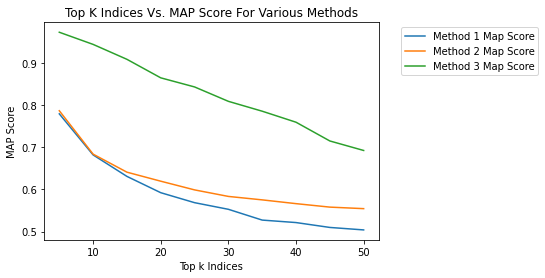

In [12]:
mapMethod1 = allProjectTop50Indexes.iloc[0]
mapMethod2 = allProjectTop50Indexes.iloc[1]
mapMethod3 = allProjectTop50Indexes.iloc[2]
xLabels = [5,10,15,20,25,30,35,40,45,50]

fig, ax = plt.subplots()
plt.plot(xLabels, mapMethod1, label = "Method 1 Map Score")
plt.plot(xLabels, mapMethod2, label = "Method 2 Map Score")
plt.plot(xLabels, mapMethod3, label = "Method 3 Map Score")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Top K Indices Vs. MAP Score For Various Methods")
plt.ylabel("MAP Score")
plt.xlabel("Top k Indices")
plt.show()

As seen above the scores for Method 2 are better than Method 1 which means that Method 2 is better than Method 1. Method 3 performs better than Method 1 and 2. Additionally, as the number of indices increase the MAP score decreases.

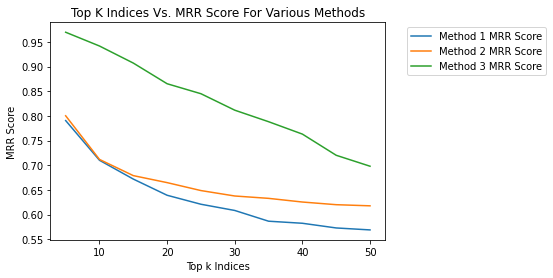

In [13]:
mrrMethod1 = allProjectTop50Indexes.iloc[3]
mrrMethod2 = allProjectTop50Indexes.iloc[4]
mrrMethod3 = allProjectTop50Indexes.iloc[5]
xLabels = [5,10,15,20,25,30,35,40,45,50]

fig, ax = plt.subplots()
plt.plot(xLabels, mrrMethod1, label = "Method 1 MRR Score")
plt.plot(xLabels, mrrMethod2, label = "Method 2 MRR Score")
plt.plot(xLabels, mrrMethod3, label = "Method 3 MRR Score")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Top K Indices Vs. MRR Score For Various Methods")
plt.ylabel("MRR Score")
plt.xlabel("Top k Indices")
plt.show()

As seen above the scores for Method 2 are better than Method 1 which means that Method 2 is better than Method 1.Method 3 performs better than Method 1 and 2. Additionally, as the number of indices increases the MRR score decreases.

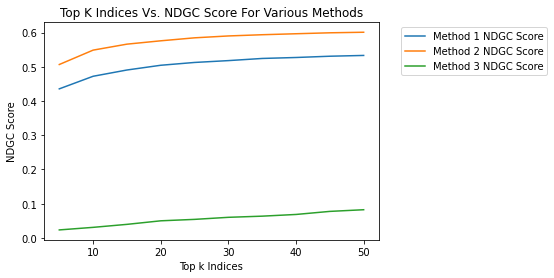

In [14]:
ndgcMethod1 = allProjectTop50Indexes.iloc[6]
ndgcMethod2 = allProjectTop50Indexes.iloc[7]
ndgcMethod3 = allProjectTop50Indexes.iloc[8]
xLabels = [5,10,15,20,25,30,35,40,45,50]

fig, ax = plt.subplots()
plt.plot(xLabels, ndgcMethod1, label = "Method 1 NDGC Score")
plt.plot(xLabels, ndgcMethod2, label = "Method 2 NDGC Score")
plt.plot(xLabels, ndgcMethod3, label = "Method 3 NDGC Score")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Top K Indices Vs. NDGC Score For Various Methods")
plt.ylabel("NDGC Score")
plt.xlabel("Top k Indices")
plt.show()

As seen above the scores for Method 2 are better than Method 1 which means that Method 2 is better than Method 1.  Method 3 performs worse than Method 1 and 2. It can also be seen in the graph above, the NDGC score increases as the number of recommendations increase. 